In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import talib 
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib.colors import ListedColormap
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



In [160]:
startdate = '2016-01-1'
enddate= '2021-12-31'
scaler = MinMaxScaler()

In [161]:
dji = pdr.get_data_yahoo('^DJI', start=startdate, end=enddate)
dji_norm = pd.DataFrame(scaler.fit_transform(dji), columns=dji.columns)
n225 = pdr.get_data_yahoo("^N225", start=startdate, end=enddate)
n225_norm = pd.DataFrame(scaler.fit_transform(n225), columns=n225.columns)
hsi = pdr.get_data_yahoo("^HSI", start=startdate, end=enddate)
hsi_norm = pd.DataFrame(scaler.fit_transform(hsi), columns=hsi.columns)
sse = pdr.get_data_yahoo("000001.SS", start=startdate, end=enddate)
sse_norm = pd.DataFrame(scaler.fit_transform(sse), columns=sse.columns)


<h1>Dow Jones Industrial Average</h1>

<h2>Feature Selection</h2>

In [162]:
dji['Future Close'] = dji['Close'].shift(-1)
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2015-12-31,17590.660156,17421.160156,17590.660156,17425.029297,93690000,17425.029297,17148.939453
2016-01-04,17405.480469,16957.630859,17405.480469,17148.939453,148060000,17148.939453,17158.660156
2016-01-05,17195.839844,17038.609375,17147.500000,17158.660156,105750000,17158.660156,16906.509766
2016-01-06,17154.830078,16817.619141,17154.830078,16906.509766,120250000,16906.509766,16514.099609
2016-01-07,16888.359375,16463.630859,16888.359375,16514.099609,176240000,16514.099609,16346.450195
...,...,...,...,...,...,...,...
2021-11-24,35825.468750,35591.031250,35752.308594,35804.378906,280960000,35804.378906,34899.339844
2021-11-26,35366.691406,34749.800781,35366.691406,34899.339844,324580000,34899.339844,35135.941406
2021-11-29,35287.910156,34895.890625,35017.710938,35135.941406,416040000,35135.941406,34483.718750


In [163]:
def computeTarget(present_price, future_price):
    score = (( future_price - present_price ) / present_price ) * 100
    target = []
    for i in score:
        if i > 0.01:
            target.append(1)
        elif i <= 0.01:
            target.append(0)
        else:
            target.append(0)
    return target
# 1 = up, 0 = down

In [164]:

target = computeTarget(dji['Close'], dji['Future Close'])

dji['Target'] = target


In [165]:
close = dji['Close']
high = dji['High']
low = dji['Low']
open = dji['Open']
volume  = dji['Volume']

In [166]:
dji_ti = pd.DataFrame()
dji_ti['SMA20'] = talib.SMA(close, timeperiod=20)
dji_ti['SMA50'] = talib.SMA(close, timeperiod=50)
dji_ti['SMA200'] = talib.SMA(close, timeperiod=200)
dji_ti['EMA'] = talib.EMA(close, timeperiod=14)
dji_ti['OBV'] = talib.OBV(close, volume)
dji_ti['RSI14'] = talib.RSI(close, timeperiod=14)
dji_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
dji_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
dji_ti['aroondown'], dji_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
dji_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
dji_ti['BOP'] = talib.BOP(open, high, low, close)
dji_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
dji_ti['CMO'] = talib.CMO(close, timeperiod=14)
dji_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
dji_ti['macd'],dji_ti['macdsignal'],dji_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
dji_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
dji_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
dji_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
dji_ti['MOM'] = talib.MOM(close, timeperiod=14)
dji_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
dji_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
dji_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['ROC'] = talib.ROC(close, timeperiod=10)
dji_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
dji_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
dji_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
dji_ti['slowk'], dji_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
dji_ti['fastk'], dji_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
dji_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
dji_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
dji_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
dji_ti['Target'] = dji['Target']
dji_ti['Re Target'] = dji['Close']
dji_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,9.369000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17425.029297
2016-01-04,NaN,NaN,NaN,NaN,-5.437000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,17148.939453
2016-01-05,NaN,NaN,NaN,NaN,5.138000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17158.660156
2016-01-06,NaN,NaN,NaN,NaN,-6.887000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16906.509766
2016-01-07,NaN,NaN,NaN,NaN,-2.451100e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16514.099609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,35992.551172,35258.370156,34298.362393,35867.366660,4.001491e+10,51.576985,17.811202,20.964972,92.857143,14.285714,...,99.236245,38.711528,24.643130,63.820092,38.711528,0.059878,44.607981,-74.433650,0,35804.378906
2021-11-26,35950.994141,35261.330547,34315.705596,35738.296418,3.969033e+10,34.109686,19.447525,22.442660,100.000000,7.142857,...,97.155190,40.139149,32.776595,12.674312,40.139149,0.059385,35.974968,-91.765151,1,34899.339844
2021-11-29,35916.813281,35272.351797,34334.093301,35657.982416,4.010637e+10,39.845233,20.966969,23.406884,92.857143,0.000000,...,97.328646,36.407362,38.419346,32.727682,36.407362,0.058300,39.725168,-76.838692,0,35135.941406


In [167]:
dji_target = dji_ti.tail(1)
dji_target
dji_ti = dji_ti.dropna()

In [168]:
def selectFeatures(df, target):
    #Split the features and target data
    #select the first 13 columns as features
    X = df.drop(target, axis=1)  # Feature Matrix
    #Select the last column for target 
    Y = df[target]               # Target Variable

    #Build a logistic regression model 
    model = LinearRegression()
    #Define RFE 
    rfe = RFE(model)
    #Use RFE to select the top 5 features 
    fit = rfe.fit(X, Y)

    #Create a dataframe for the results 
    df_RFE_results = []
    for i in range(X.shape[1]):
        df_RFE_results.append(
            {      
                'Feature_names': X.columns[i],
                'Selected':  rfe.support_[i],
                'RFE_ranking':  rfe.ranking_[i],
            }
        )

    df_RFE_results = pd.DataFrame(df_RFE_results)
    df_RFE_results.index.name='Columns'
    ti = []
    for index, row in df_RFE_results.iterrows():
        if row['Selected'] == True:
            ti.append(row['Feature_names']) 
    return ti

In [169]:
dji_features = selectFeatures(dji_ti,'Target')
dji_features

['RSI14',
 'ADX',
 'ADXR',
 'aroondown',
 'BOP',
 'CCI',
 'CMO',
 'macdhist',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [170]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [171]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [172]:
# def visualize(title, xlabel, ylabel, classifier, X_test, y_test):
#     X_set, y_set = X_test, y_test
#     X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                          np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
#     plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#                  alpha = 0.75, cmap = ListedColormap(('lightblue', 'cornsilk')))
#     plt.xlim(X1.min(), X1.max())
#     plt.ylim(X2.min(), X2.max())

#     for i, j in enumerate(np.unique(y_set)):
#         plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend()
#     plt.show()

<h2>Decision Tree</h2>

In [173]:
# Decision Tree Classifier: Create and Train the model
#
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [174]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], dtype=int64)

In [175]:
# Look at the actual y_test
#
#y_test


In [176]:
from sklearn import metrics
cla = "classification"
reg = "regression"
def evaluate(task, y_test, y_pred):
    evaluate = []
    if task == cla:
        evaluate.append(metrics.accuracy_score(y_test, y_pred))
        evaluate.append(metrics.confusion_matrix(y_test, y_pred))
        evaluate.append(metrics.f1_score(y_test, y_pred))
        evaluate.append(metrics.precision_score(y_test, y_pred))
        evaluate.append(metrics.recall_score(y_test, y_pred))
        evaluate.append(metrics.roc_auc_score(y_test, y_pred))
    elif task == reg:
       evaluate.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
       evaluate.append(metrics.r2_score(y_test, y_pred))
    return evaluate


In [177]:
def printEval(task, evaluation):
    if task == cla:
        print("Accuracy Score: ", evaluation[0])
        print("Confusion Matrix: \n", evaluation[1])
        print("F1 Score: ", evaluation[2])
        print("Precision Score: ", evaluation[3])
        print("Recall score: ", evaluation[4])
        print("Area Under Curve score: ", evaluation[5])
    elif task == reg:
        print("Root Mean Squared Error: ", evaluation[0])
        print("R2 Error", evaluation[1])

In [178]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)


Accuracy Score:  0.5173745173745173
Confusion Matrix: 
 [[48 55]
 [70 86]]
F1 Score:  0.5791245791245792
Precision Score:  0.6099290780141844
Recall score:  0.5512820512820513
Area Under Curve score:  0.5086507343788897


<h2>Random Forest</h2>

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [180]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=2)
forest.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Temp/ipykernel_18372/3312196032.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=42)

In [181]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [182]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.583011583011583
Confusion Matrix: 
 [[  0 103]
 [  5 151]]
F1 Score:  0.7365853658536586
Precision Score:  0.594488188976378
Recall score:  0.967948717948718
Area Under Curve score:  0.483974358974359


<h2>Logistic Regression</h2>

In [183]:
# Logistic Regression Classifier: Create and Train the model
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [184]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [185]:
# Look at the actual y_test
y_test

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [186]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.5482625482625483
Confusion Matrix: 
 [[ 28  75]
 [ 42 114]]
F1 Score:  0.6608695652173913
Precision Score:  0.6031746031746031
Recall score:  0.7307692307692307
Area Under Curve score:  0.5013069454817027


<h2>XGBoost</h2>

In [187]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\

[15:08:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [188]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

In [189]:
y_test

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [190]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5019305019305019
Confusion Matrix: 
 [[52 51]
 [78 78]]
F1 Score:  0.5473684210526316
Precision Score:  0.6046511627906976
Recall score:  0.5
Area Under Curve score:  0.5024271844660194


<h2>Linear Regression</h2>

In [191]:
dji_features = selectFeatures(dji_ti,'Re Target')
dji_features

['SMA20',
 'EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'Target']

In [192]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [193]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [194]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [195]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 2.14028797e+03  2.19711602e+03 -1.19015207e+13  2.11645178e+01
   2.58935859e+01  1.19015207e+13  1.86767021e+02  1.10327553e+01
   1.33360953e+02 -5.14861807e+02 -1.60473089e+02  3.91481456e+02
  -7.16303416e+00 -8.83808415e+13  8.83808415e+13 -1.70772969e+01
   6.39425294e+01  1.87754727e+01 -1.45700836e+00]]
Intercept: [26271.69918765]


In [196]:
predicted = lr.predict(X_train)
print(predicted)

[[25924.37531364]
 [26223.64845361]
 [24114.68084926]
 ...
 [35617.02806411]
 [23435.33167301]
 [26806.97355699]]


In [197]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [198]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Root Mean Squared Error:  27084.16482045019
R2 Error -35.13731421721697


<AxesSubplot:>

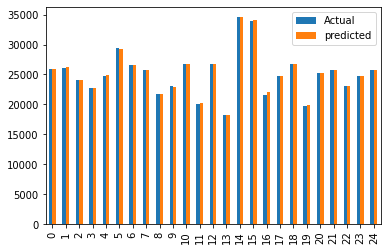

In [199]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gaussian Process Regress</h2>

In [200]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gs = GaussianProcessRegressor(kernel=kernel)
gs.fit(Xr_train, yr_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1))

In [201]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[26224.31751478],
       [26273.20136983],
       [26226.846506  ],
       [26195.91990544],
       [26239.50035952],
       [26213.08436364],
       [26308.65415097],
       [26297.73791948],
       [26337.3129923 ],
       [26182.75253006],
       [26462.06607848],
       [26254.43114583],
       [26263.43357727],
       [26358.19924973],
       [26300.10694973],
       [26208.51392063],
       [26325.97213345],
       [26468.62520461],
       [26254.28489544],
       [26237.31702931],
       [26254.74354387],
       [26104.10551457],
       [26441.69287711],
       [26243.80497273],
       [26090.77346456],
       [26168.16999912],
       [26272.64278002],
       [26248.14810241],
       [26239.2604136 ],
       [26302.39606825],
       [26103.98694421],
       [26368.9618921 ],
       [26261.10258725],
       [26196.19626612],
       [26252.07360386],
       [26340.34872795],
       [26326.36404996],
       [26306.60475384],
       [26308.98517261],
       [26462.15323402],


In [202]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Root Mean Squared Error:  4426.989801883894
R2 Error 0.03452280731396484


In [203]:
def avg(evaluation):
    return sum(evaluation) / len(evaluation)

In [204]:
def finalEvaluate(pred):
    down = pred.count(0)
    up = pred.count(1)
    upText = "The final prediction is Up"
    downText = "The final prediction is Down"
    print(pred)
    if up > down:
        print(upText)
        return True
    elif up < down:
        print(downText)
        return True
    else:
        return False

In [205]:
def regPredict(classifier, pred, target):
    predict = classifier.predict(pred)
    tg = target['Re Target'].values[0]
    if predict[0] > tg:
        return 1
    else:
        return 0


In [206]:
from sklearn.preprocessing import normalize
def finalPredict(target, target_features, retarget_features, dctEvaluation, forestEvaluation, logisticEvaluation, xgbEvaluation, lrEvaluation, gsEvaluation):
    X = target.loc[:, target_features].values
    X_test = sc.transform(X)
    reX = target.loc[:, retarget_features].values
    reX_test = sc.transform(reX)
    dctE = dctEvaluation.copy()
    forestE = forestEvaluation.copy()
    logisticE = logisticEvaluation.copy()
    xgbE = xgbEvaluation.copy()
    lrE = lrEvaluation.copy()
    gsE = gsEvaluation.copy()
    dctE.pop(1)
    forestE.pop(1)
    logisticE.pop(1)
    xgbE.pop(1)
    evaluation = []
    evaluation.append(avg(dctE))
    evaluation.append(avg(forestE))
    evaluation.append(avg(logisticE))
    evaluation.append(avg(xgbE))
    evaluation.append(lrE[1])
    evaluation.append(gsE[1])
    pred = []
    pred.append(dtc.predict(X_test)[0])
    pred.append(forest.predict(X_test)[0])
    pred.append(logistic.predict(X_test)[0])
    pred.append(xgb.predict(X_test)[0])
    pred.append(regPredict(lr, reX_test, target))
    pred.append(regPredict(gs, reX_test, target))
    final = finalEvaluate(pred)
    if final == False:
        min_value = min(evaluation)
        min_index = evaluation.index(min_value)
        pred.pop(min_index)
        finalEvaluate(pred)


In [207]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, gsEval)
# h = 0.02  # step size in the mesh

# names = [
#     "Decision Tree",
#     "Random Forest",
#     "XGBoost",
#     "Logistic",
# ]

# classifiers = [
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     LogisticRegression(),
#     XGBClassifier(),
    
# ]

# X, y = make_classification(
#     n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
# )
# rng = np.random.RandomState(2)
# X += 2 * rng.uniform(size=X.shape)
# linearly_separable = (X, y)

# datasets = [
#     make_moons(noise=0.3, random_state=0),
#     make_circles(noise=0.2, factor=0.5, random_state=1),
#     linearly_separable,
# ]

# figure = plt.figure(figsize=(27, 9))
# i = 1
# # iterate over datasets
# for ds_cnt, ds in enumerate(datasets):
#     # preprocess dataset, split into training and test part
#     X, y = ds
#     X = StandardScaler().fit_transform(X)
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.4, random_state=42
#     )

#     x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
#     y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#     # just plot the dataset first
#     cm = plt.cm.RdBu
#     cm_bright = ListedColormap(["#FF0000", "#0000FF"])
#     ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
#     if ds_cnt == 0:
#         ax.set_title("Input data")
#     # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
#     # Plot the testing points
#     ax.scatter(
#         X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
#     )
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     i += 1

#     # iterate over classifiers
#     for name, clf in zip(names, classifiers):
#         ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
#         clf.fit(X_train, y_train)
#         score = clf.score(X_test, y_test)

#         # Plot the decision boundary. For that, we will assign a color to each
#         # point in the mesh [x_min, x_max]x[y_min, y_max].
#         if hasattr(clf, "decision_function"):
#             Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#         else:
#             Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

#         # Plot the training points
#         ax.scatter(
#             X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
#         )
#         # Plot the testing points
#         ax.scatter(
#             X_test[:, 0],
#             X_test[:, 1],
#             c=y_test,
#             cmap=cm_bright,
#             edgecolors="k",
#             alpha=0.6,
#         )

#         ax.set_xlim(xx.min(), xx.max())
#         ax.set_ylim(yy.min(), yy.max())
#         ax.set_xticks(())
#         ax.set_yticks(())
#         if ds_cnt == 0:
#             ax.set_title(name)
#         ax.text(
#             xx.max() - 0.3,
#             yy.min() + 0.3,
#             ("%.2f" % score).lstrip("0"),
#             size=15,
#             horizontalalignment="right",
#         )
#         i += 1

# plt.tight_layout()
# plt.show()

[0, 1, 1, 1, 1, 0]
The final prediction is Up


<h1>Nikkei 225 Stock Average</h1>

<h2>Feature Selection</h2>

In [208]:
n225['Future Close'] = n225['Close'].shift(-1)
n225

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,18951.119141,18394.429688,18818.580078,18450.980469,140200000.0,18450.980469,18374.000000
2016-01-05,18547.380859,18327.519531,18398.759766,18374.000000,132300000.0,18374.000000,18191.320312
2016-01-06,18469.380859,18064.300781,18410.570312,18191.320312,142200000.0,18191.320312,17767.339844
2016-01-07,18172.039062,17767.339844,18139.769531,17767.339844,168000000.0,17767.339844,17697.960938
2016-01-08,17975.310547,17509.640625,17562.230469,17697.960938,184300000.0,17697.960938,17218.960938
...,...,...,...,...,...,...,...
2021-11-26,29332.990234,28605.609375,29324.470703,28751.619141,72900000.0,28751.619141,28283.919922
2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922,27821.759766
2021-11-30,28718.699219,27819.140625,28611.730469,27821.759766,140700000.0,27821.759766,27935.619141


In [209]:
target = computeTarget(n225['Close'], n225['Future Close'])

n225['Target'] = target

In [210]:
close = n225['Close']
high = n225['High']
low = n225['Low']
open = n225['Open']
volume  = n225['Volume']

In [211]:
n225_ti = pd.DataFrame()
n225_ti['SMA20'] = talib.SMA(close, timeperiod=20)
n225_ti['SMA50'] = talib.SMA(close, timeperiod=50)
n225_ti['SMA200'] = talib.SMA(close, timeperiod=200)
n225_ti['EMA'] = talib.EMA(close, timeperiod=14)
n225_ti['OBV'] = talib.OBV(close, volume)
n225_ti['RSI14'] = talib.RSI(close, timeperiod=14)
n225_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
n225_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
n225_ti['aroondown'], n225_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
n225_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
n225_ti['BOP'] = talib.BOP(open, high, low, close)
n225_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
n225_ti['CMO'] = talib.CMO(close, timeperiod=14)
n225_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
n225_ti['macd'],n225_ti['macdsignal'],n225_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
n225_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
n225_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
n225_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
n225_ti['MOM'] = talib.MOM(close, timeperiod=14)
n225_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
n225_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
n225_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['ROC'] = talib.ROC(close, timeperiod=10)
n225_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
n225_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
n225_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
n225_ti['slowk'], n225_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
n225_ti['fastk'], n225_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
n225_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
n225_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
n225_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
n225_ti['Target'] = n225['Target']
n225_ti['Re Target'] = n225['Close']
n225_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.402000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18450.980469
2016-01-05,NaN,NaN,NaN,NaN,7.900000e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18374.000000
2016-01-06,NaN,NaN,NaN,NaN,-1.343000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18191.320312
2016-01-07,NaN,NaN,NaN,NaN,-3.023000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17767.339844
2016-01-08,NaN,NaN,NaN,NaN,-4.866000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17697.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,29450.963379,29255.414609,28947.439170,29407.880747,5.676300e+09,41.224743,11.884684,13.210618,100.000000,50.000000,...,98.202600,24.424769,37.981001,12.158555,24.424769,0.044831,41.192014,-89.226918,0,28751.619141
2021-11-29,29424.154883,29207.691016,28945.626270,29258.019304,5.590400e+09,36.087929,14.019772,13.770901,100.000000,42.857143,...,95.521607,22.126310,29.701132,5.977677,22.126310,0.043856,39.061709,-94.542778,0,28283.919922
2021-11-30,29370.608398,29153.891992,28943.025322,29066.518032,5.449700e+09,31.862883,16.441484,14.666264,100.000000,35.714286,...,93.434348,6.090439,17.547172,0.135083,6.090439,0.041502,31.087620,-99.877712,1,27821.759766


In [212]:

n225_target = n225_ti.tail(1)

In [213]:
n225_ti = n225_ti.dropna()
n225_features = selectFeatures(n225_ti, 'Target')
n225_features

['RSI14',
 'ADX',
 'ADXR',
 'aroondown',
 'BOP',
 'CMO',
 'DX',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [214]:
X = n225_ti.loc[:, n225_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = n225_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [215]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [216]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [217]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

In [218]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [219]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.468
Confusion Matrix: 
 [[63 59]
 [74 54]]
F1 Score:  0.44813278008298757
Precision Score:  0.4778761061946903
Recall score:  0.421875
Area Under Curve score:  0.4691342213114754


<h2>Random Forest</h2>

In [220]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 43, max_depth=4, min_samples_split=2 )
forest.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Temp/ipykernel_18372/2696115339.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=43)

In [221]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1], dtype=int64)

In [222]:
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [223]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.492
Confusion Matrix: 
 [[57 65]
 [62 66]]
F1 Score:  0.5096525096525096
Precision Score:  0.5038167938931297
Recall score:  0.515625
Area Under Curve score:  0.49141905737704916


<h2>Logistic Regression</h2>

In [224]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [225]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

In [226]:
# Look at the actual y_test
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [227]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.528
Confusion Matrix: 
 [[56 66]
 [52 76]]
F1 Score:  0.562962962962963
Precision Score:  0.5352112676056338
Recall score:  0.59375
Area Under Curve score:  0.5263831967213114


<h2>XGBoost</h2>

In [228]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[15:08:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [229]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1], dtype=int64)

In [230]:
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [231]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5
Confusion Matrix: 
 [[52 70]
 [55 73]]
F1 Score:  0.5387453874538746
Precision Score:  0.5104895104895105
Recall score:  0.5703125
Area Under Curve score:  0.49827100409836067


<h2>Linear Regress</h2>

In [232]:
n225_features = selectFeatures(n225_ti,'Re Target')
n225_features

['EMA',
 'RSI14',
 'ADX',
 'ADXR',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'slowk',
 'slowd',
 'fastk',
 'TRIX',
 'ULTOSC']

In [233]:
from sklearn.model_selection import train_test_split
X = n225_ti.loc[:, n225_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = n225_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [234]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [235]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [236]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[3212.15022811  220.40129887   16.7155904   -27.27941328   14.32766068
   220.40129887 -144.5308115    -9.4676657   215.99799754 -505.73376472
  -254.00051843  366.68468547  -43.04611213   -3.57801072   19.07656185
   -20.90298029   23.56956758  -11.34377927   13.38377456]]
Intercept: [22815.24223648]


In [237]:
predicted = lr.predict(X_train)
print(predicted)

[[22694.35623742]
 [21674.80856659]
 [21618.08148251]
 [23298.53884313]
 [22129.08412713]
 [20057.86810932]
 [28994.34432482]
 [23234.97570051]
 [29435.00359982]
 [20611.79335405]
 [30283.40154738]
 [24165.99845093]
 [21725.28204617]
 [21485.24803964]
 [22576.62038976]
 [21629.39437254]
 [22205.91487156]
 [24267.70207855]
 [17716.5278432 ]
 [29482.39000489]
 [26286.83918233]
 [21002.27026201]
 [28616.20667843]
 [19841.38651853]
 [29172.16123641]
 [19225.31711228]
 [22703.69296728]
 [19045.67153061]
 [20635.73256136]
 [21155.20993453]
 [28089.19473373]
 [21488.18169657]
 [28253.67379024]
 [28068.19398754]
 [21522.02393008]
 [19360.79819674]
 [29618.52983024]
 [23888.38470987]
 [23325.12744024]
 [21281.89132438]
 [24316.30986537]
 [21775.10345295]
 [23379.65790125]
 [18816.08908072]
 [21451.68383091]
 [21980.75523665]
 [22319.47511301]
 [22460.30591956]
 [23256.95530658]
 [22860.56625169]
 [21138.27187028]
 [22939.88902795]
 [18902.88877786]
 [29464.3325059 ]
 [22774.80279839]
 [24303.60

In [238]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [239]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Root Mean Squared Error:  23405.937977052487
R2 Error -47.66460621254784


<AxesSubplot:>

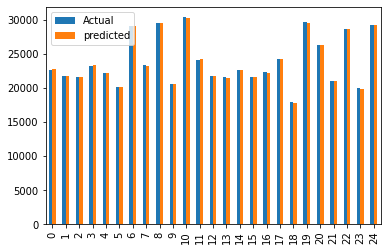

In [240]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gaussian Process Regression</h2>

In [241]:
n225_refeatures = selectFeatures(n225_ti,'Re Target')
n225_refeatures

['EMA',
 'RSI14',
 'ADX',
 'ADXR',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'slowk',
 'slowd',
 'fastk',
 'TRIX',
 'ULTOSC']

In [242]:
Xr = n225_ti.loc[:, n225_refeatures].values
yr = n225_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [243]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [244]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gs = GaussianProcessRegressor(kernel=kernel)
gs.fit(Xr_train, yr_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1))

In [245]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[22969.89999658],
       [22780.25131816],
       [22749.31761014],
       [22775.54842669],
       [22784.19162911],
       [22808.50385135],
       [22896.28502235],
       [22782.22802517],
       [22809.47232127],
       [22884.62484032],
       [22816.65277556],
       [22831.34474587],
       [22802.39368042],
       [22774.98521474],
       [22805.61705253],
       [22826.01874441],
       [22969.42615539],
       [22843.08728334],
       [22996.25415817],
       [22750.37101111],
       [22845.27335855],
       [22822.21033853],
       [22795.22967896],
       [22842.66564041],
       [22726.57734936],
       [22776.43281847],
       [22763.38395181],
       [22753.35276955],
       [22732.47332466],
       [22796.14441472],
       [22952.94506019],
       [22742.01821935],
       [22821.34487885],
       [22803.09552494],
       [22758.48827505],
       [22828.78105995],
       [22767.6888231 ],
       [22792.42930043],
       [22883.49089471],
       [22792.08958822],


In [246]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Root Mean Squared Error:  3325.6556067836445
R2 Error 0.017538229488853196


[1, 1, 0, 0, 1, 1]
The final prediction is Up


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


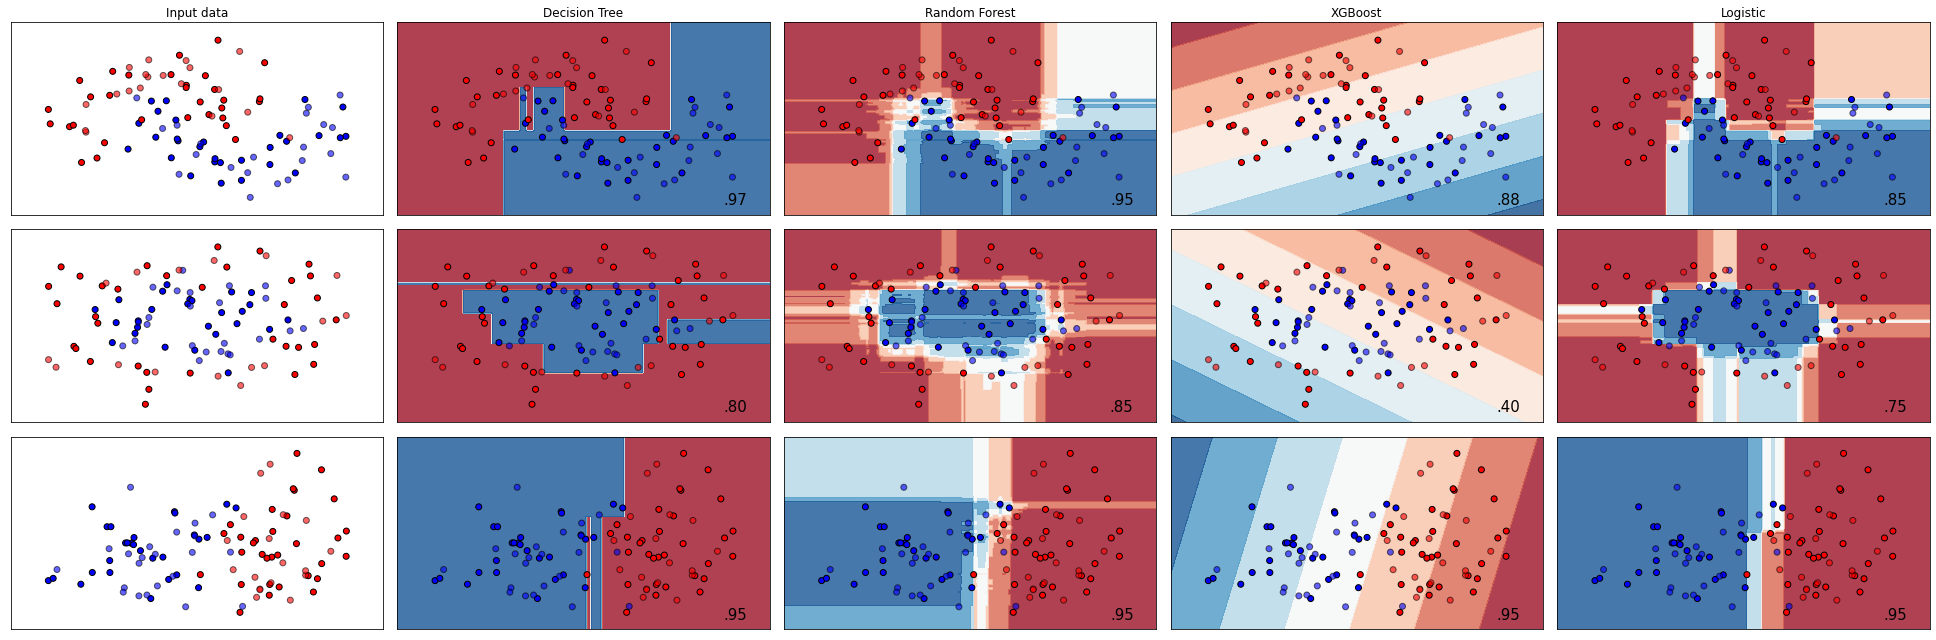

In [247]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, gsEval)
h = 0.02  

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
   
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

   
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
   
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
   
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

      
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

<h1>Heng Seng Index</h1>

<h2>Feature Selection</h2>

In [248]:
hsi['Future Close'] = hsi['Close'].shift(-1)
hsi

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,21794.839844,21227.609375,21782.619141,21327.119141,1.712095e+09,21327.119141,21188.720703
2016-01-05,21452.740234,21095.900391,21318.689453,21188.720703,1.484745e+09,21188.720703,20980.810547
2016-01-06,21199.619141,20947.300781,21142.630859,20980.810547,1.651083e+09,20980.810547,20333.339844
2016-01-07,20826.439453,20323.970703,20772.599609,20333.339844,2.982004e+09,20333.339844,20453.710938
2016-01-08,20596.419922,20324.619141,20491.880859,20453.710938,2.078133e+09,20453.710938,19888.500000
...,...,...,...,...,...,...,...
2021-11-26,24502.679688,24062.259766,24502.679688,24080.519531,1.804123e+09,24080.519531,23852.240234
2021-11-29,24134.320312,23774.310547,23910.490234,23852.240234,1.741008e+09,23852.240234,23475.259766
2021-11-30,23888.369141,23175.369141,23782.859375,23475.259766,3.344858e+09,23475.259766,23658.919922


In [249]:
target = computeTarget(hsi['Close'], hsi['Future Close'])

hsi['Target'] = target


In [250]:
close = hsi['Close']
high = hsi['High']
low = hsi['Low']
open = hsi['Open']
volume  = hsi['Volume']

In [251]:
hsi_ti = pd.DataFrame()
hsi_ti['SMA20'] = talib.SMA(close, timeperiod=20)
hsi_ti['SMA50'] = talib.SMA(close, timeperiod=50)
hsi_ti['SMA200'] = talib.SMA(close, timeperiod=200)
hsi_ti['EMA'] = talib.EMA(close, timeperiod=14)
hsi_ti['OBV'] = talib.OBV(close, volume)
hsi_ti['RSI14'] = talib.RSI(close, timeperiod=14)
hsi_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
hsi_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
hsi_ti['aroondown'], hsi_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
hsi_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
hsi_ti['BOP'] = talib.BOP(open, high, low, close)
hsi_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
hsi_ti['CMO'] = talib.CMO(close, timeperiod=14)
hsi_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
hsi_ti['macd'],hsi_ti['macdsignal'],hsi_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
hsi_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
hsi_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
hsi_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
hsi_ti['MOM'] = talib.MOM(close, timeperiod=14)
hsi_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
hsi_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
hsi_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['ROC'] = talib.ROC(close, timeperiod=10)
hsi_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
hsi_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
hsi_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
hsi_ti['slowk'], hsi_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
hsi_ti['fastk'], hsi_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
hsi_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
hsi_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
hsi_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
hsi_ti['Target'] = hsi['Target']
hsi_ti['Re Target'] = hsi['Close']
hsi_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.712095e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21327.119141
2016-01-05,NaN,NaN,NaN,NaN,2.273497e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21188.720703
2016-01-06,NaN,NaN,NaN,NaN,-1.423734e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20980.810547
2016-01-07,NaN,NaN,NaN,NaN,-4.405738e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20333.339844
2016-01-08,NaN,NaN,NaN,NaN,-2.327604e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20453.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,25037.850098,25026.557266,27336.604980,24923.428580,1.847527e+11,32.311086,16.161043,15.541943,100.000000,42.857143,...,95.074808,17.749029,15.509999,1.759656,17.749029,-0.056914,37.989503,-98.915981,0,24080.519531
2021-11-29,24972.746094,24993.557461,27310.298682,24780.603467,1.830117e+11,29.872744,18.157605,16.725154,100.000000,35.714286,...,93.940076,15.184520,17.046495,7.234342,15.184520,-0.058054,37.122164,-96.048992,0,23852.240234
2021-11-30,24891.525586,24962.398438,27281.231582,24606.557641,1.796668e+11,26.337965,20.745865,17.735988,100.000000,28.571429,...,91.294475,8.961841,13.965130,17.891526,8.961841,-0.060435,35.699137,-88.337193,1,23475.259766


In [252]:
hsi_target = hsi_ti.tail(1)

In [253]:
hsi_ti = hsi_ti.dropna()
hsi_features = selectFeatures(hsi_ti,'Target')
hsi_features

['RSI14',
 'ADX',
 'APO',
 'BOP',
 'CCI',
 'CMO',
 'DX',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'TRIX',
 'WILLR']

In [254]:
X = hsi_ti.loc[:, hsi_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [255]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [256]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [257]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [258]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [259]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.4642857142857143
Confusion Matrix: 
 [[52 68]
 [67 65]]
F1 Score:  0.490566037735849
Precision Score:  0.48872180451127817
Recall score:  0.49242424242424243
Area Under Curve score:  0.4628787878787879


<h2>Random Forest</h2>

In [260]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 40, max_depth=2 )
forest.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Temp/ipykernel_18372/33020272.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=40)

In [261]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [262]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.49603174603174605
Confusion Matrix: 
 [[  9 111]
 [ 16 116]]
F1 Score:  0.6462395543175486
Precision Score:  0.5110132158590308
Recall score:  0.8787878787878788
Area Under Curve score:  0.47689393939393937


<h2>Logistic Regression</h2>

In [263]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [264]:
# Prediction
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [265]:
# Look at the actual y_test
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [266]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.4642857142857143
Confusion Matrix: 
 [[52 68]
 [67 65]]
F1 Score:  0.490566037735849
Precision Score:  0.48872180451127817
Recall score:  0.49242424242424243
Area Under Curve score:  0.4628787878787879


<h2>XGBoost</h2>

In [267]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\

[15:08:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [268]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [269]:
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [270]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.47619047619047616
Confusion Matrix: 
 [[49 71]
 [61 71]]
F1 Score:  0.5182481751824818
Precision Score:  0.5
Recall score:  0.5378787878787878
Area Under Curve score:  0.47310606060606053


<h2>Linear Regression</h2>

In [271]:
hsi_features = selectFeatures(hsi_ti,'Re Target')
hsi_features

['EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'WILLR',
 'Target']

In [272]:
from sklearn.model_selection import train_test_split
X = hsi_ti.loc[:, hsi_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [273]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [274]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [275]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 2.25423833e+03 -4.69216444e+12  5.08920576e+00  1.65498349e+01
   4.69216444e+12 -2.26925073e+02 -2.57016981e+01  2.59203532e+02
  -5.25856945e+02 -2.51599848e+02  3.38069876e+02  2.90114156e+01
  -7.71215777e+14  7.71215777e+14 -8.16880882e+00  5.31836769e+01
   2.42811430e+01 -1.38024902e+01 -8.10997009e-01]]
Intercept: [26928.36252681]


In [276]:
predicted = lr.predict(X_train)
print(predicted)

[[25656.05000532]
 [27704.726717  ]
 [27072.60385136]
 ...
 [24495.89245293]
 [27969.80494463]
 [26094.09379313]]


In [277]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [278]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Root Mean Squared Error:  27010.214349082475
R2 Error -126.75584290803017


<AxesSubplot:>

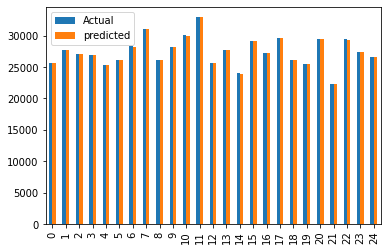

In [279]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gaussian Process Regression</h2>

In [280]:
hsi_refeatures = selectFeatures(hsi_ti,'Re Target')
hsi_refeatures

['EMA',
 'RSI14',
 'ADX',
 'BOP',
 'CMO',
 'macdsignal',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'fastk',
 'TRIX',
 'WILLR',
 'Target']

In [281]:
Xr = hsi_ti.loc[:, hsi_refeatures].values
yr = hsi_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [282]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [283]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gs = GaussianProcessRegressor(kernel=kernel)
gs.fit(Xr_train, yr_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1))

In [284]:
yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[26816.42101899],
       [26786.20109648],
       [26894.08341667],
       [26886.9411149 ],
       [26966.89455414],
       [26798.38680497],
       [26942.48045632],
       [26873.64413896],
       [26930.20613709],
       [26980.15272143],
       [26986.44101229],
       [26880.69578877],
       [26855.44575334],
       [26840.43938929],
       [26910.67907533],
       [26834.17067373],
       [26850.70866463],
       [26865.46958655],
       [26873.49898434],
       [26848.19017351],
       [26850.97451606],
       [26900.72818366],
       [26922.55103374],
       [26793.31856862],
       [26838.00946924],
       [26946.60085452],
       [26918.99025354],
       [26967.83817422],
       [26903.75631672],
       [26913.06097582],
       [26886.76815212],
       [26923.06035781],
       [26905.85128021],
       [26803.49413118],
       [26901.33903885],
       [26865.21873713],
       [26889.42096266],
       [26825.17217019],
       [26822.17662755],
       [27095.86306214],


In [285]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Root Mean Squared Error:  2343.7698626883416
R2 Error 0.03804525437708628


[1, 1, 0, 1, 0, 1]
The final prediction is Up


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


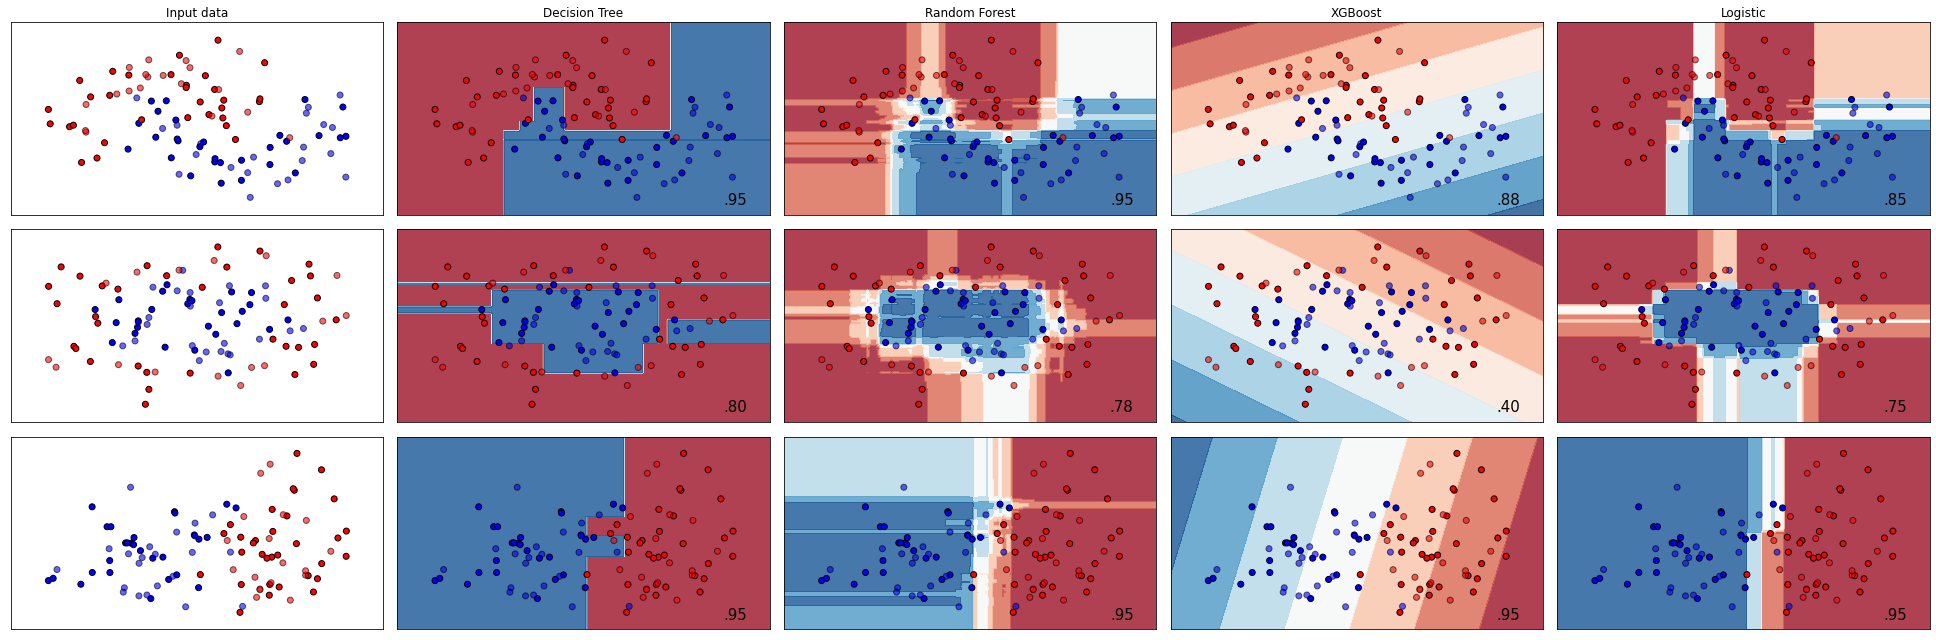

In [286]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, gsEval)
h = 0.02  # step size in the mesh

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

   
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
   
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
   
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

      
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()


<h1>SSE Composite Index</h1>

<h2>Feature Selection</h2>

In [287]:
sse['Future Close'] = sse['Close'].shift(-1)
sse

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,3538.688965,3295.740967,3536.589111,3296.258057,184400,3296.258057,3287.710938
2016-01-05,3328.138916,3189.604980,3196.650879,3287.710938,266900,3287.710938,3361.840088
2016-01-06,3362.974121,3288.933105,3291.195068,3361.840088,238900,3361.840088,3125.001953
2016-01-07,3309.656982,3115.885010,3309.656982,3125.001953,70600,3125.001953,3186.412109
2016-01-08,3235.450928,3056.877930,3194.625000,3186.412109,286400,3186.412109,3016.704102
...,...,...,...,...,...,...,...
2021-11-26,3576.110107,3554.879883,3576.110107,3564.090088,301000,3564.090088,3562.699951
2021-11-29,3563.679932,3526.360107,3528.669922,3562.699951,333600,3562.699951,3563.889893
2021-11-30,3582.120117,3546.360107,3570.750000,3563.889893,349200,3563.889893,3576.889893


In [288]:
target = computeTarget(sse['Close'], sse['Future Close'])

sse['Target'] = target

In [289]:
close = sse['Close']
high = sse['High']
low = sse['Low']
open = sse['Open']
volume  = sse['Volume']

In [290]:
sse_ti = pd.DataFrame()
sse_ti['SMA20'] = talib.SMA(close, timeperiod=20)
sse_ti['SMA50'] = talib.SMA(close, timeperiod=50)
sse_ti['SMA200'] = talib.SMA(close, timeperiod=200)
sse_ti['EMA'] = talib.EMA(close, timeperiod=14)
sse_ti['OBV'] = talib.OBV(close, volume)
sse_ti['RSI14'] = talib.RSI(close, timeperiod=14)
sse_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
sse_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
sse_ti['aroondown'], sse_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
sse_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
sse_ti['BOP'] = talib.BOP(open, high, low, close)
sse_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
sse_ti['CMO'] = talib.CMO(close, timeperiod=14)
sse_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
sse_ti['macd'],sse_ti['macdsignal'],sse_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
sse_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
sse_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
sse_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
sse_ti['MOM'] = talib.MOM(close, timeperiod=14)
sse_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
sse_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
sse_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['ROC'] = talib.ROC(close, timeperiod=10)
sse_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
sse_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
sse_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
sse_ti['slowk'], sse_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
sse_ti['fastk'], sse_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
sse_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
sse_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
sse_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
sse_ti['Target'] = sse['Target']
sse_ti['Re Target'] = sse['Close']
sse_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,ROCR100,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.844000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3296.258057
2016-01-05,NaN,NaN,NaN,NaN,-8.250000e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3287.710938
2016-01-06,NaN,NaN,NaN,NaN,1.564000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3361.840088
2016-01-07,NaN,NaN,NaN,NaN,8.580000e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3125.001953
2016-01-08,NaN,NaN,NaN,NaN,3.722000e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3186.412109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,3536.137622,3574.640054,3526.238558,3557.457359,2.485770e+07,52.144400,18.673887,22.533847,14.285714,85.714286,...,100.706111,62.081553,79.550737,19.245976,62.081553,-0.007953,61.348117,-25.046163,0,3564.090088
2021-11-29,3537.048621,3572.031455,3526.526178,3558.156371,2.452410e+07,51.831473,18.346326,22.970243,7.142857,78.571429,...,100.832081,48.339676,65.263526,47.580810,48.339676,-0.007703,68.169630,-25.947123,1,3562.699951
2021-11-30,3539.961621,3569.247051,3526.930282,3558.920841,2.487330e+07,52.096479,17.369247,22.381258,0.000000,71.428571,...,101.195411,38.655207,49.692145,49.138835,38.655207,-0.007386,61.739004,-32.396652,1,3563.889893


In [291]:
sse_target = hsi_ti.tail(1)

In [292]:
sse_ti = sse_ti.dropna()
sse_features = selectFeatures(sse_ti,'Target')
sse_features

['SMA20',
 'EMA',
 'APO',
 'BOP',
 'CCI',
 'DX',
 'macd',
 'macdsignal',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastd',
 'TRIX']

In [293]:
X = sse_ti.loc[:, sse_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = sse_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [294]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [295]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [296]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1], dtype=int64)

In [297]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
    

In [298]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.5201612903225806
Confusion Matrix: 
 [[63 61]
 [58 66]]
F1 Score:  0.5258964143426295
Precision Score:  0.5196850393700787
Recall score:  0.532258064516129
Area Under Curve score:  0.5201612903225806


<h2>Random Forest</h2>

In [299]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features=9)
forest.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Temp/ipykernel_18372/371548984.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_features=9, n_estimators=1000, random_state=42)

In [300]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1], dtype=int64)

In [301]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.532258064516129
Confusion Matrix: 
 [[50 74]
 [42 82]]
F1 Score:  0.5857142857142856
Precision Score:  0.5256410256410257
Recall score:  0.6612903225806451
Area Under Curve score:  0.532258064516129


<h2>Logistic Regression</h2>

In [302]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [303]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [304]:
# Look at the actual y_test
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
    

In [305]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.5120967741935484
Confusion Matrix: 
 [[37 87]
 [34 90]]
F1 Score:  0.5980066445182725
Precision Score:  0.5084745762711864
Recall score:  0.7258064516129032
Area Under Curve score:  0.5120967741935484


<h2>XGBoost</h2>

In [306]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\

[15:08:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [307]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1], dtype=int64)

In [308]:
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
    

In [309]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5483870967741935
Confusion Matrix: 
 [[64 60]
 [52 72]]
F1 Score:  0.5625
Precision Score:  0.5454545454545454
Recall score:  0.5806451612903226
Area Under Curve score:  0.5483870967741935


<h2>Linear Regression</h2>

In [310]:
sse_features = selectFeatures(sse_ti,'Re Target')
sse_features

['SMA20',
 'SMA50',
 'EMA',
 'RSI14',
 'ADXR',
 'APO',
 'BOP',
 'CMO',
 'macd',
 'macdsignal',
 'macdhist',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'TRIX']

In [311]:
from sklearn.model_selection import train_test_split
X = sse_ti.loc[:, sse_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = sse_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [312]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [313]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [314]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 1.18426390e+02 -5.70256504e+01  2.18977976e+02  2.57282118e+10
  -1.04447411e+00  3.69206891e+00  2.97172470e+00 -2.57282117e+10
  -1.03477625e+10  9.64545140e+09  3.40274159e+09  2.93480743e+01
  -5.00463731e+01 -2.97825813e+01  5.20431311e+01  6.79603563e+00
  -1.94736521e+12  1.94736521e+12  1.11863471e+00]]
Intercept: [3154.73087159]


In [315]:
predicted = lr.predict(X_train)
print(predicted)

[[3603.84889803]
 [2955.00115684]
 [3036.93735102]
 [2797.18839875]
 [3350.54749292]
 [3419.38477451]
 [2891.78850658]
 [3488.61722227]
 [3484.87748723]
 [3665.92405769]
 [3298.41856763]
 [3576.15838933]
 [3094.15594558]
 [3492.37096821]
 [3463.62882459]
 [3669.07206156]
 [2847.01768837]
 [3219.5583608 ]
 [3542.40629353]
 [3087.79462049]
 [3557.4551307 ]
 [3598.37444109]
 [3279.6912767 ]
 [3454.53630279]
 [3230.94456089]
 [2609.50465748]
 [3146.1196738 ]
 [3519.34743395]
 [3481.31776813]
 [2912.82708443]
 [3061.1490859 ]
 [3073.97887936]
 [2788.30508509]
 [2990.00561469]
 [3221.2004118 ]
 [2727.40041794]
 [3488.69826936]
 [2905.94475491]
 [2939.957407  ]
 [2729.69853008]
 [3656.94229364]
 [3578.64719332]
 [3527.27082364]
 [2716.92482367]
 [3398.79031331]
 [3058.2253119 ]
 [3352.39031822]
 [2534.1175935 ]
 [3279.58054743]
 [2913.07734742]
 [2494.16017075]
 [3135.33331459]
 [2814.23435929]
 [2936.66717589]
 [3578.20327964]
 [3003.90076159]
 [2874.58855788]
 [2969.14776977]
 [3483.1306333

In [316]:
dframe = pd.DataFrame({'Actual':y_train.flatten(),'predicted':predicted.flatten()})

In [317]:
#evaluate("reg", y_test, y_pred)

lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Root Mean Squared Error:  3138.6794327646326
R2 Error -109.95005596983947


<AxesSubplot:>

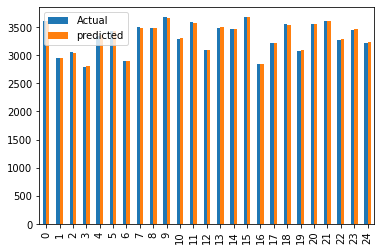

In [318]:
graph = dframe.head(25)
graph.plot(kind='bar')

<h2>Gaussian Process Regression</h2>

In [319]:
sse_refeatures = selectFeatures(sse_ti,'Re Target')
sse_refeatures

['SMA20',
 'SMA50',
 'EMA',
 'RSI14',
 'ADXR',
 'APO',
 'BOP',
 'CMO',
 'macd',
 'macdsignal',
 'macdhist',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'TRIX']

In [320]:
Xr = sse_ti.loc[:, sse_refeatures].values
yr = sse_ti.loc[:, ['Re Target']].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=0)

In [321]:
from sklearn.preprocessing import StandardScaler
scr = StandardScaler()
Xr_train = sc.fit_transform(Xr_train)
Xr_test = sc.transform(Xr_test)

In [322]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gs = GaussianProcessRegressor(kernel=kernel)
gs.fit(Xr_train, yr_train)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1))

In [323]:

yr_pred = gs.predict(Xr_test)  #Accuracy
yr_pred

array([[3178.497607  ],
       [3152.12037118],
       [3145.477535  ],
       [3152.77711456],
       [3143.18126187],
       [3168.09481253],
       [3163.87778964],
       [3122.1376709 ],
       [3168.35383099],
       [3170.27786724],
       [3163.64247168],
       [3147.44023083],
       [3160.45827498],
       [3169.46945748],
       [3169.9704092 ],
       [3149.60307289],
       [3133.27461945],
       [3145.9509038 ],
       [3172.83882586],
       [3155.58089816],
       [3170.34432038],
       [3120.02783825],
       [3130.48193016],
       [3171.25224716],
       [3170.20716424],
       [3142.7081649 ],
       [3162.61011521],
       [3149.87087649],
       [3170.39676443],
       [3150.26339696],
       [3142.22727186],
       [3156.39543601],
       [3133.77388453],
       [3131.63571732],
       [3171.80610488],
       [3140.04307047],
       [3148.06931482],
       [3179.69190442],
       [3157.42888334],
       [3146.43205093],
       [3127.36217631],
       [3159.151

In [324]:
gsEval = evaluate(reg, yr_test, yr_pred)
printEval(reg, gsEval)

Root Mean Squared Error:  284.62137385186065
R2 Error 0.08763498477674792


[0, 1, 0, 1, 0, 0]
The final prediction is Down


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ME\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


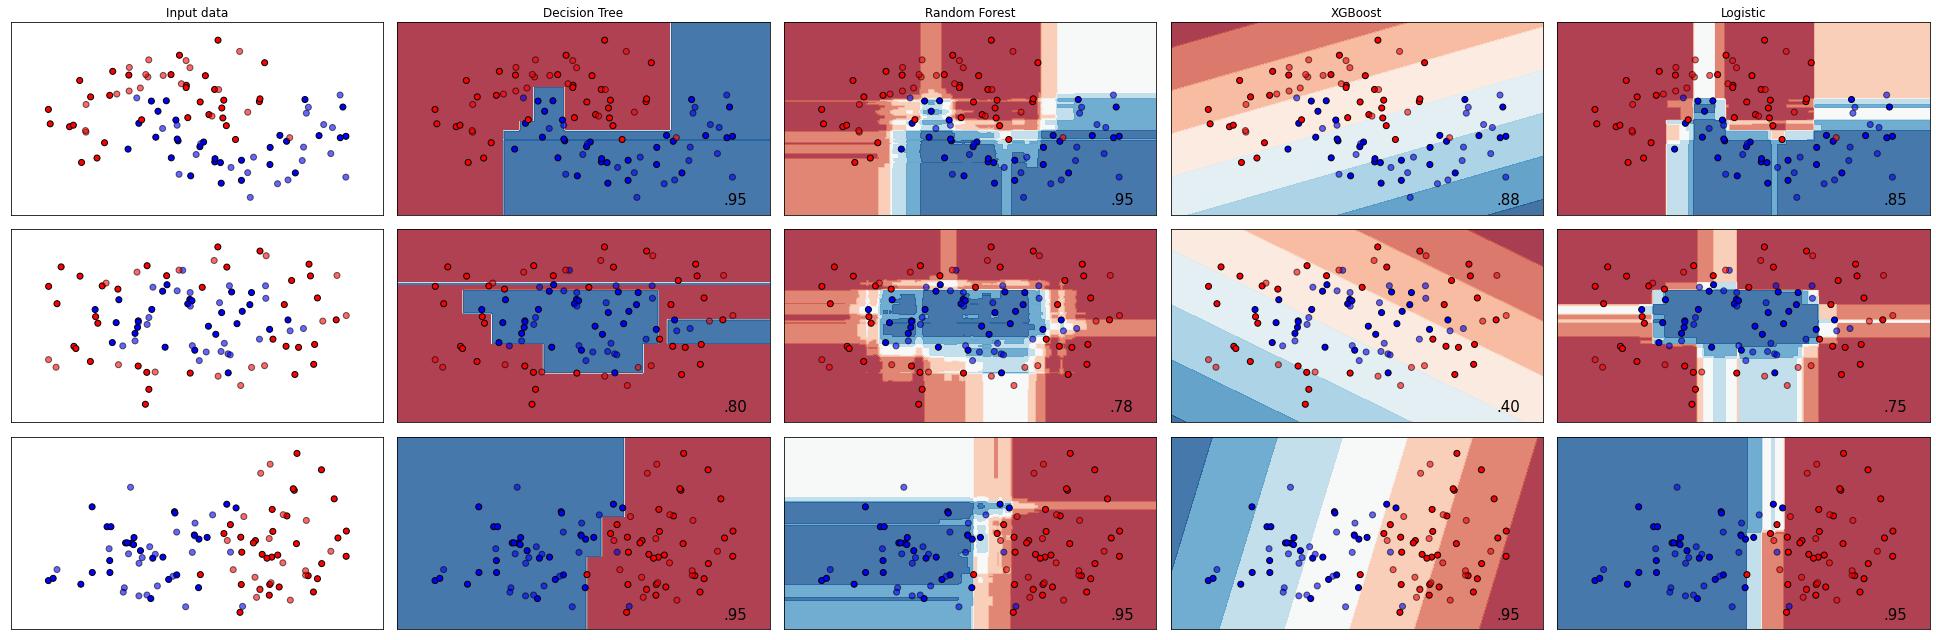

In [325]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, gsEval)

h = 0.02  # step size in the mesh

names = [
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Logistic",
]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()